In [1]:
# import from skimage
from skimage.color import rgb2gray
from skimage.filters import sobel, sobel_h, sobel_v, prewitt, roberts, gaussian
from skimage.feature import canny
import skimage.io as io
import cv2 as cv

from scipy.spatial import distance as dist

# import from matplotlib
import matplotlib.pyplot as plt

# import from numpy
import numpy as np

# import utils
from utils.commonfunctions import *

In [2]:
# img = io.imread("datasets/dataset_module1/01.jpg")

# read image 1.jpg
img = cv.imread('dataset/inputs/CameraTwo0.jpeg',0)
# colored_img = cv.imread('datasets/dataset_module1/01.jpg')
# img = cv.imread('datasets/dataset_module1/11.jpg',0)

# # convert to greyscale
# grey_scale = img
# # blurredImg = img
# # blurredImg =  cv.medianBlur(img,7)
# blurredImg = cv.GaussianBlur(img,(5,5),0)
# # blurredImg = gaussian(img,sigma = 2)

# print(img.shape)

In [3]:
# show_images([img,blurredImg])

In [4]:
# binaryImg = cv.adaptiveThreshold(blurredImg,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,59,3)
# # ret,binaryImg = cv.threshold(blurredImg,147,255,cv.THRESH_BINARY)
# show_images([img,blurredImg,binaryImg])

In [5]:
# median =  cv.medianBlur(binaryImg,5)
# median =  cv.medianBlur(median,5)
# show_images([img,blurredImg,binaryImg,median])

In [6]:
# kernel = np.ones((3,3))
# openingImg = opening(median, kernel)
# dilatedImg = dilate(openingImg, kernel)
# show_images([median,openingImg,dilatedImg])

In [7]:
# negativeImg = 255-binaryImg
# kernel = np.ones((7,7))
# erodedImg = erode(negativeImg, kernel)
# show_images([negativeImg,erodedImg,dilatedImg])

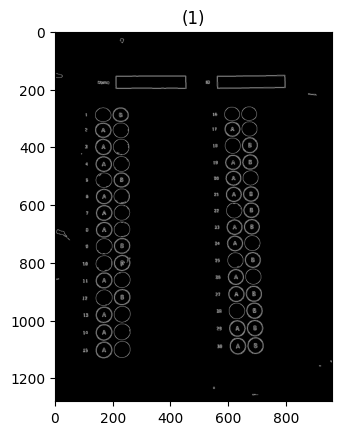

In [8]:
# use canny to detect edges
cannyEdges = cannyEdge(img)

show_images([cannyEdges])

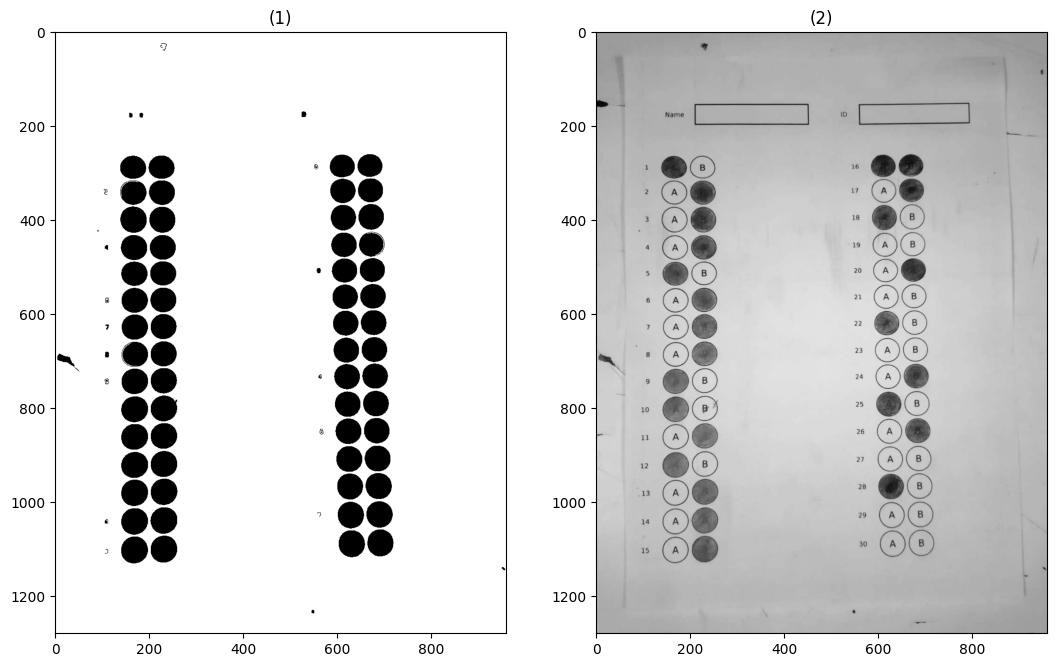

In [9]:
# Finding Contours
# Use a copy of the image e.g. edged.copy()
# since findContours alters the image
img_cpy = img.copy()
img_cpy = cv.adaptiveThreshold(img_cpy,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,59,3)
contours, hierarchy = cv.findContours(cannyEdges, 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

white_img_contours = np.ones(img_cpy.shape)
sorted_contours = sorted(contours, key=cv.contourArea)
for contour in sorted_contours:
    x,y,w,h = cv.boundingRect(contour)
    if w/h >= 0.7 and w/h <=1.3:
        cv.fillPoly(white_img_contours, pts =[contour], color=(0,0,0))
show_images([white_img_contours,img])

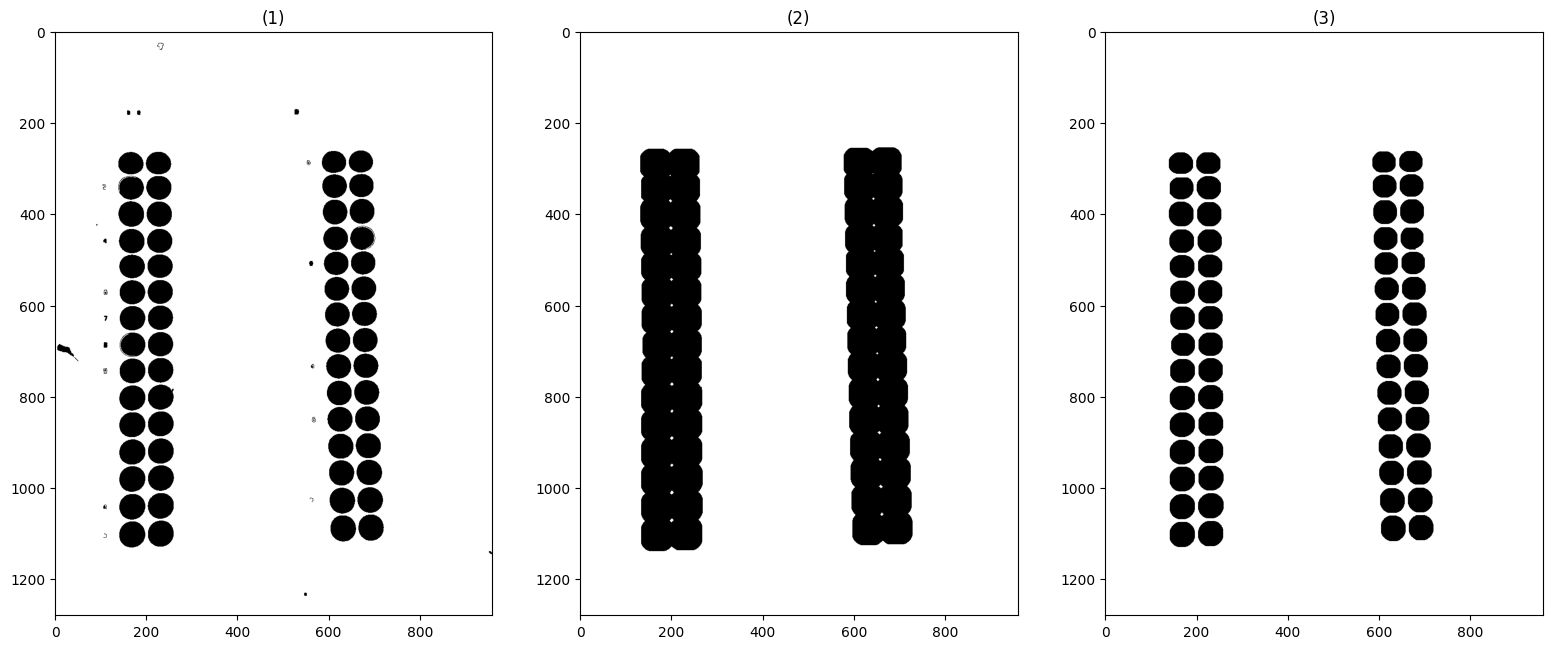

In [10]:
kernel = np.ones((15,15))
dilatedImg = dilate(white_img_contours, kernel)

kernel = np.ones((15,15))
erodedImg2 = erode(dilatedImg, kernel)

kernel = np.ones((18,18))
erodedImg = erode(erodedImg2, kernel)
show_images([white_img_contours,erodedImg,erodedImg2])

[(132, 258, 137, 882), (578, 255, 151, 872)]


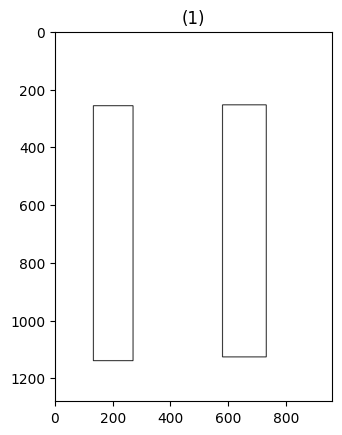

In [11]:
contours, hierarchy = cv.findContours((255 - erodedImg*255).astype("uint8"), 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
white_img_large_contours = np.ones(img_cpy.shape)
# computes the bounding box for the contour, and draws it on the frame,

dimensions_contours = []
for contour in contours:
    (x,y,w,h) = cv.boundingRect(contour)
    dimensions_contours.append( (x,y,w,h))
    cv.rectangle(white_img_large_contours, (x,y), (x+w,y+h), (0, 0, 0), 2)
print(dimensions_contours)
show_images([white_img_large_contours])

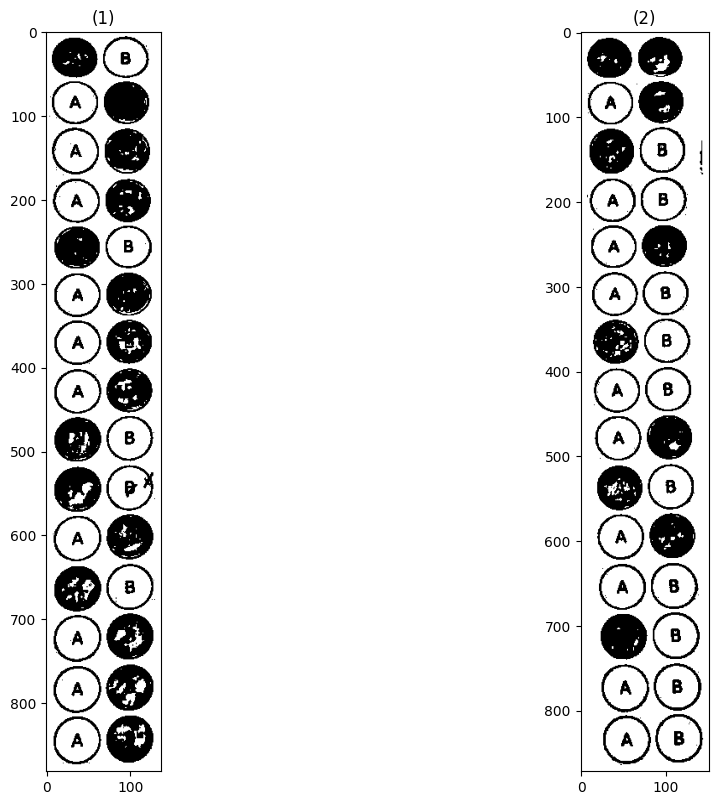

In [12]:
croped_images = []

for dimension in dimensions_contours:
    (x,y,w,h) = dimension
    croped_images.append(img_cpy[y:y+h,x:x+w])
show_images(croped_images)

47


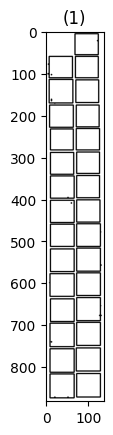

46


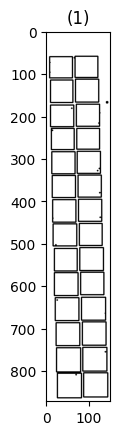

[1, 4, 4, 1, 4, 2, 2, 2, 3, 3, 1, 3, 2, 3, 1, 4, 3, 2]


In [13]:
def find_contours_to_rect(img):
    contours, hierarchy = cv.findContours((255-img).astype("uint8"), 
    cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    white_img_large_contours = np.ones(img.shape)
    # computes the bounding box for the contour, and draws it on the frame,
    
    sorted_contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[1])
    dimensions_contours = []
    for contour in sorted_contours:
        (x,y,w,h) = cv.boundingRect(contour)
        if w/h >= 0.9 and w/h <=1.1:
            dimensions_contours.append((x,y,w,h))
            cv.rectangle(white_img_large_contours, (x,y), (x+w,y+h), (0, 0, 0), 2)
    print(len(dimensions_contours))
    return white_img_large_contours,dimensions_contours

contour_cropped_imgs = []
dimensions_cropped_imgs = []
for image in croped_images:
    result_img,result_dimenstion = find_contours_to_rect(image)
    contour_cropped_imgs.append([result_img])
    dimensions_cropped_imgs.append(result_dimenstion)
    show_images([result_img])

contours_count = []
non_overlapped_cnts = []
for dimensions_cropped_img in dimensions_cropped_imgs[0]:
    isOverlapped = False
    for contour in non_overlapped_cnts:
        (x,y,w,h) = dimensions_cropped_img
        (x1,y1,w1,h1) = contour
        if (x>=x1 and x<=x1+w1) or (x+w>=x1 and x+w<=x1+w1):
            isOverlapped = True
            break
    if isOverlapped:
        contours_count.append(len(non_overlapped_cnts))
        non_overlapped_cnts = []
        non_overlapped_cnts.append(dimensions_cropped_img)
    else:
        non_overlapped_cnts.append(dimensions_cropped_img)
    #print(non_overlapped_cnts)
        
print(contours_count)


In [14]:
contours_count = np.array(contours_count)
frequency = [0]*np.max(contours_count+1)

for count in contours_count:
    frequency[count] = frequency[count] + 1
print(frequency)
answer_count = frequency.index(max(frequency))
print(answer_count)


[0, 4, 5, 5, 4]
2


In [15]:
groups_questions_answers = []
for i in range(len(dimensions_cropped_imgs)):
    dimensions_cropped_img = dimensions_cropped_imgs[i]
    question_count = len(dimensions_cropped_img)//answer_count
    questions_answers = []
    print(answer_count,question_count)
    groups_questions_answers.append([])
    for question in range(question_count):
        questions_answers = []
        cropped_answers = []
        for j in range(answer_count):
            (x,y,w,h) = dimensions_cropped_img[question*answer_count+j]
            cropped_answers.append((x,croped_images[i][y:y+h, x:x+w]))
        sorted_cropped_answers = sorted(cropped_answers,key=lambda ans: ans[0])
        
        for cropped_answer in sorted_cropped_answers:
            #show_images([cropped_answer[1]])
            questions_answers.append(cropped_answer[1])
        groups_questions_answers[i].append(questions_answers)
        
        


2 23
2 23


groups_questions_answers 2
group 23


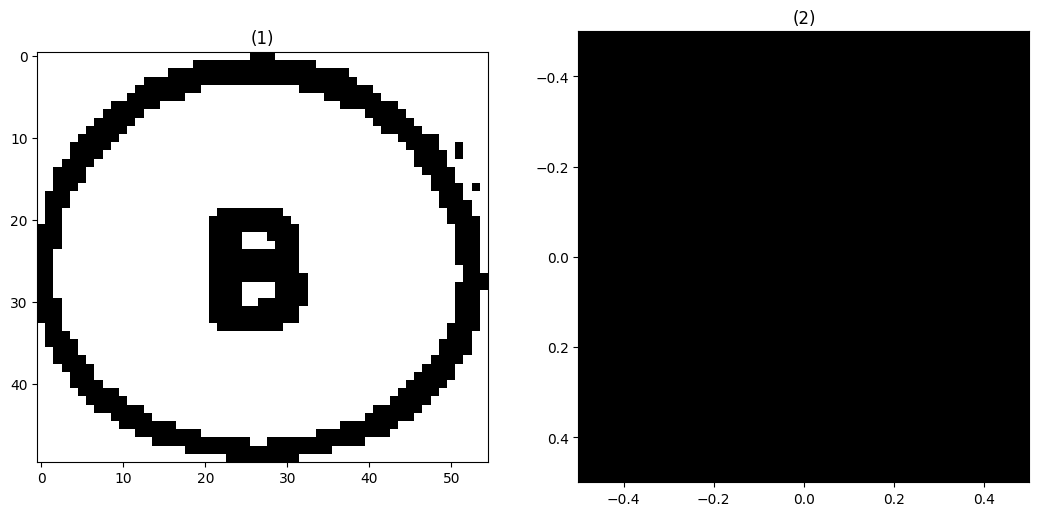

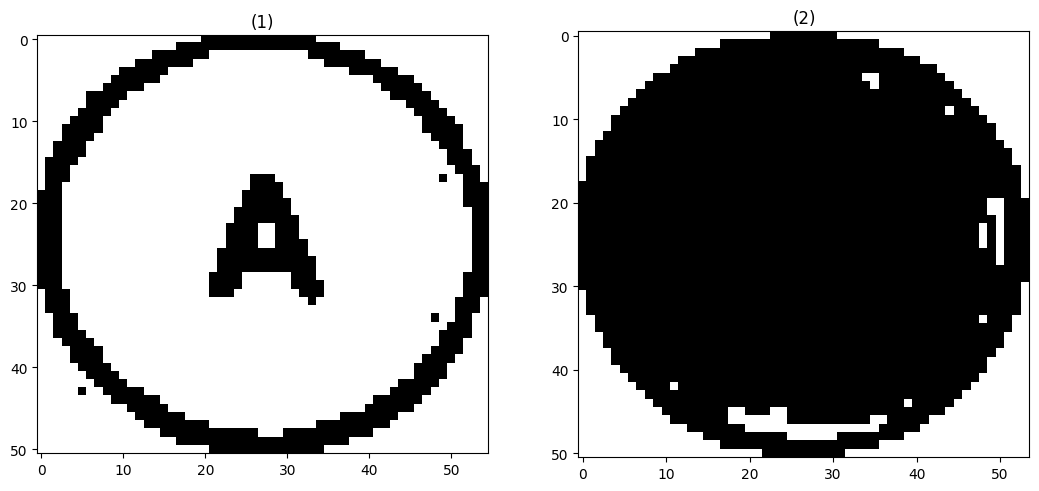

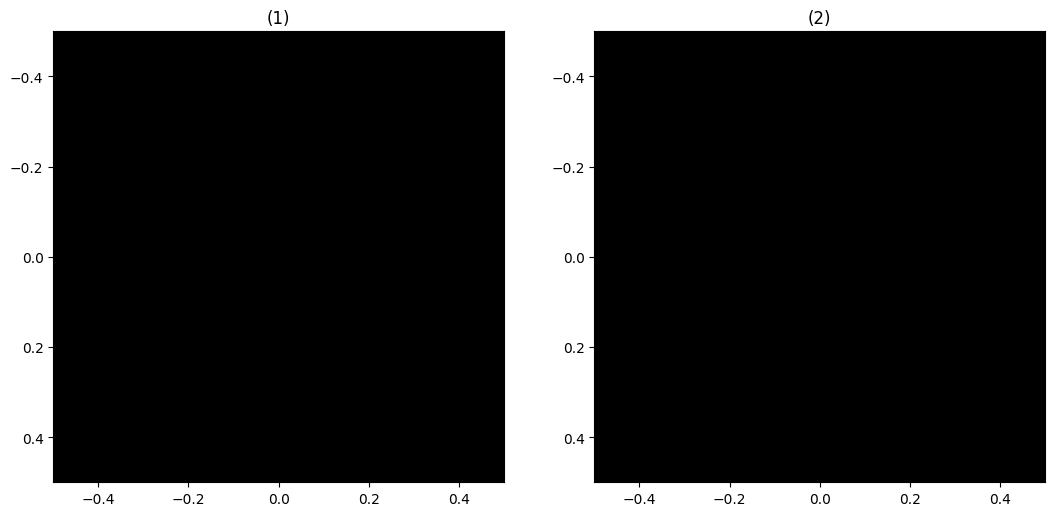

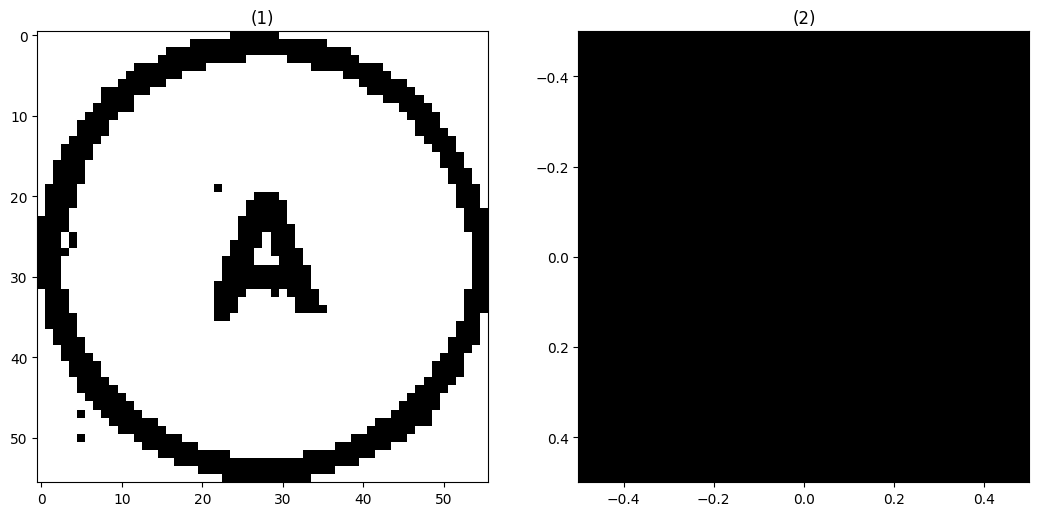

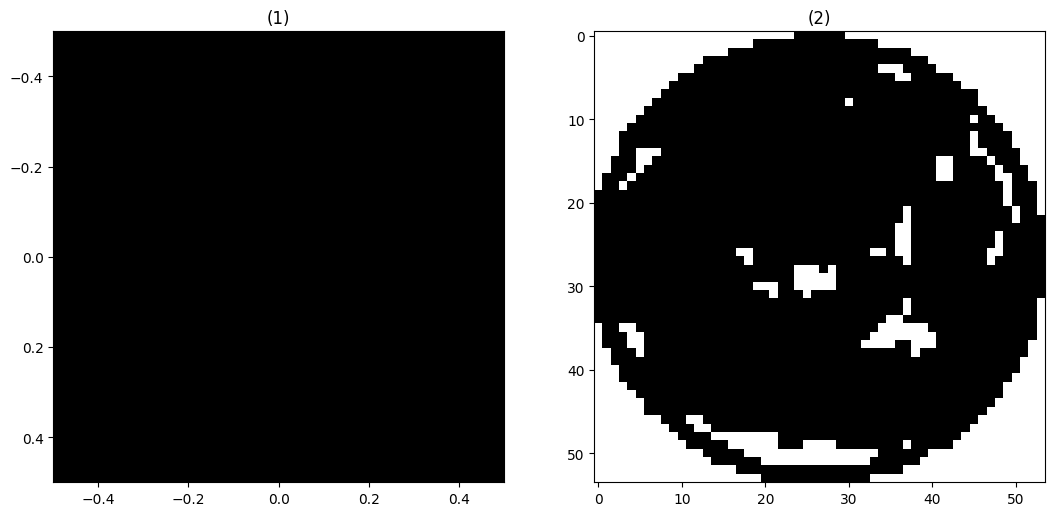

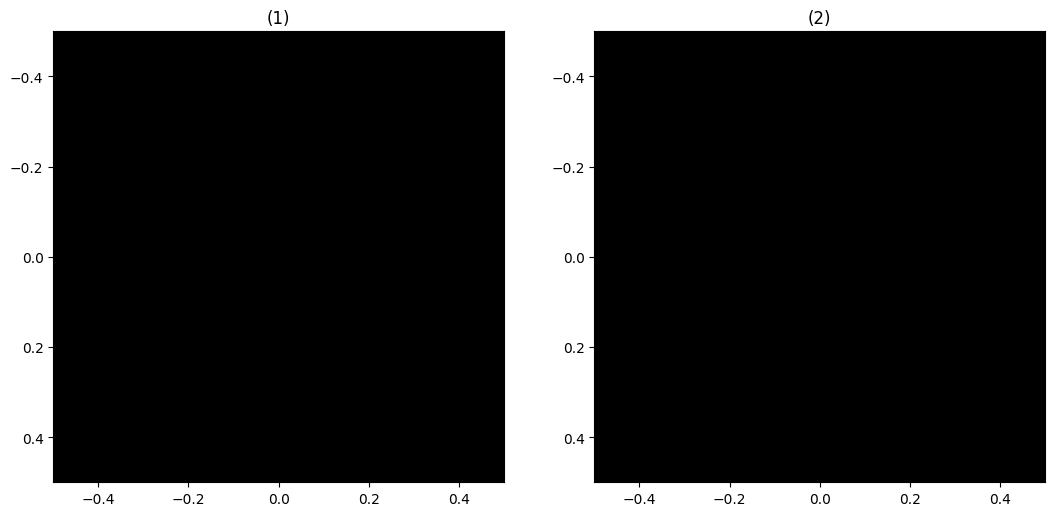

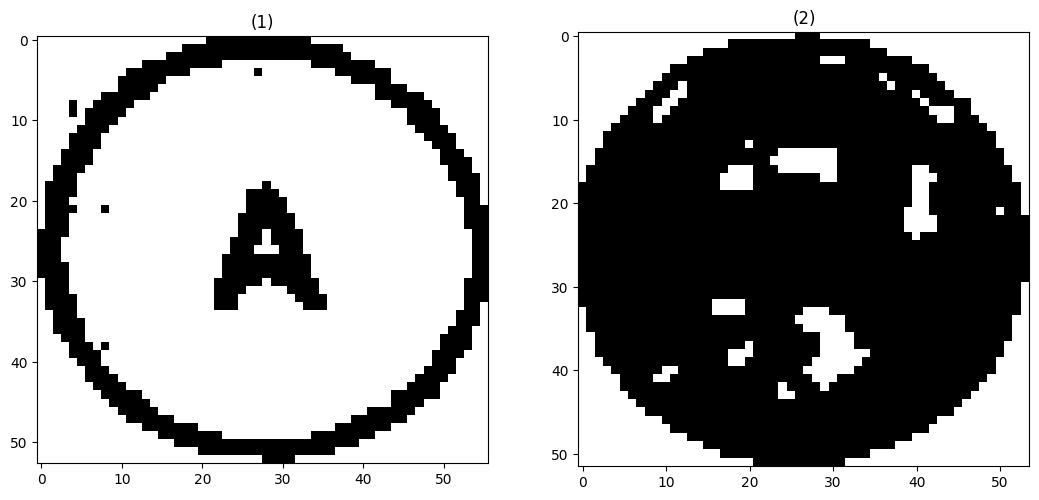

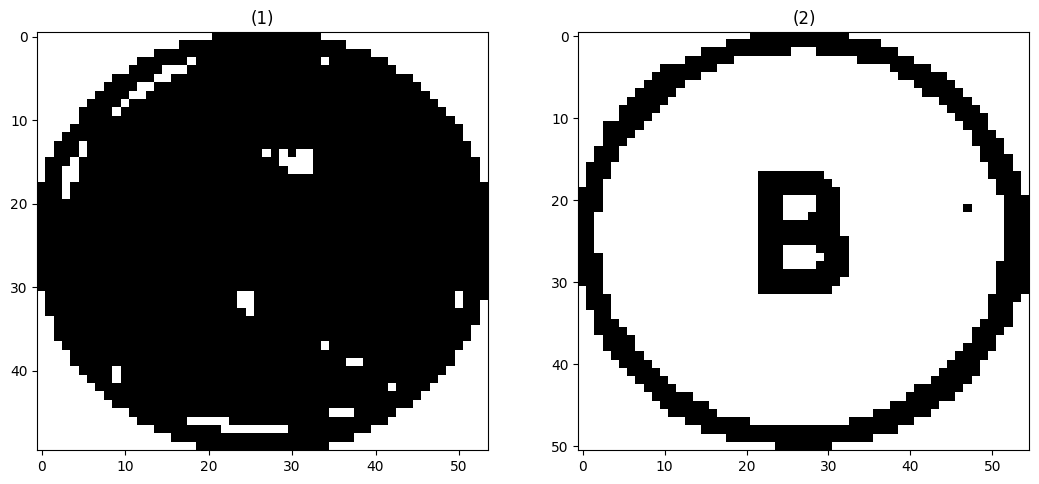

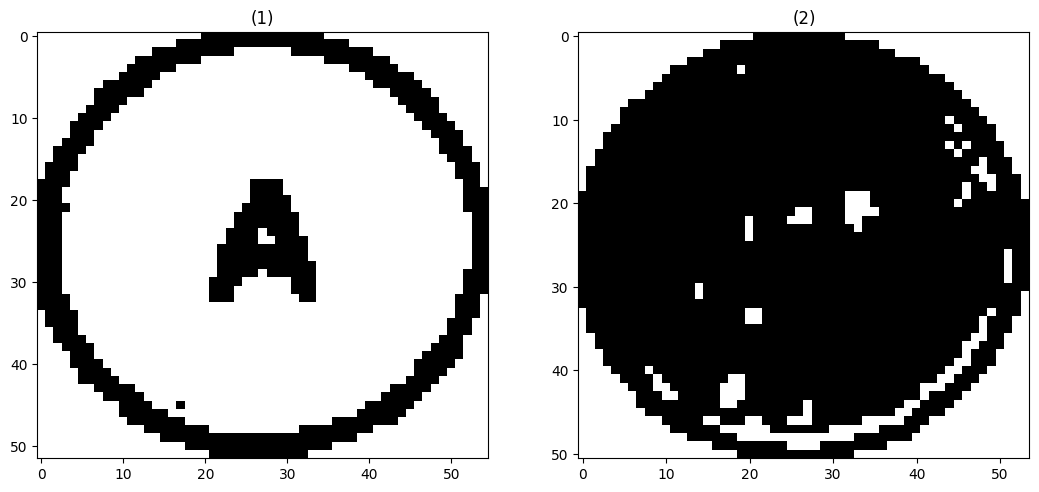

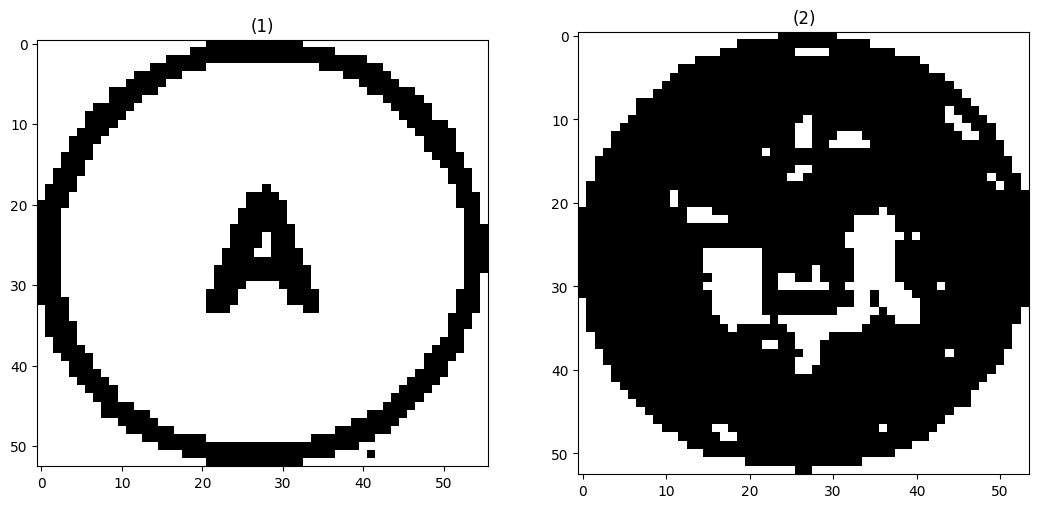

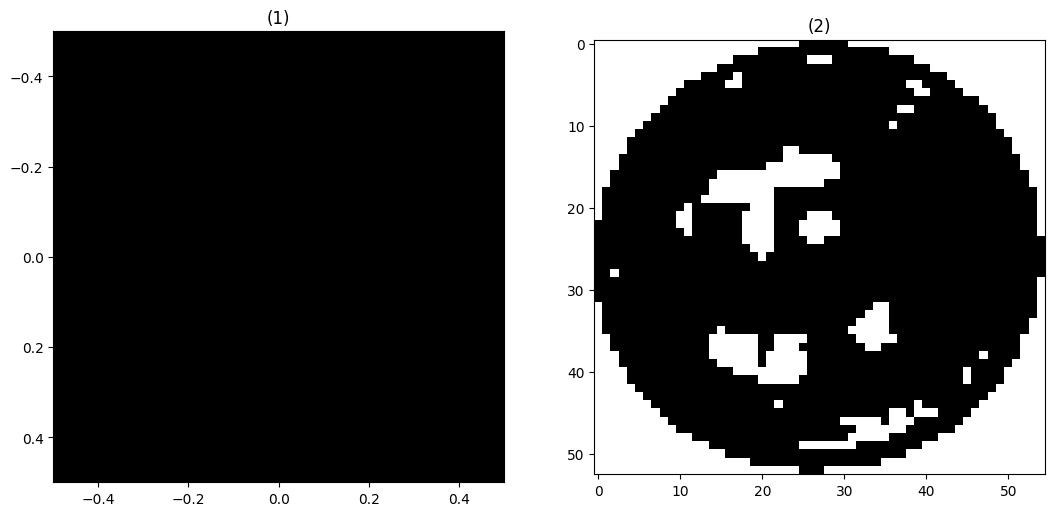

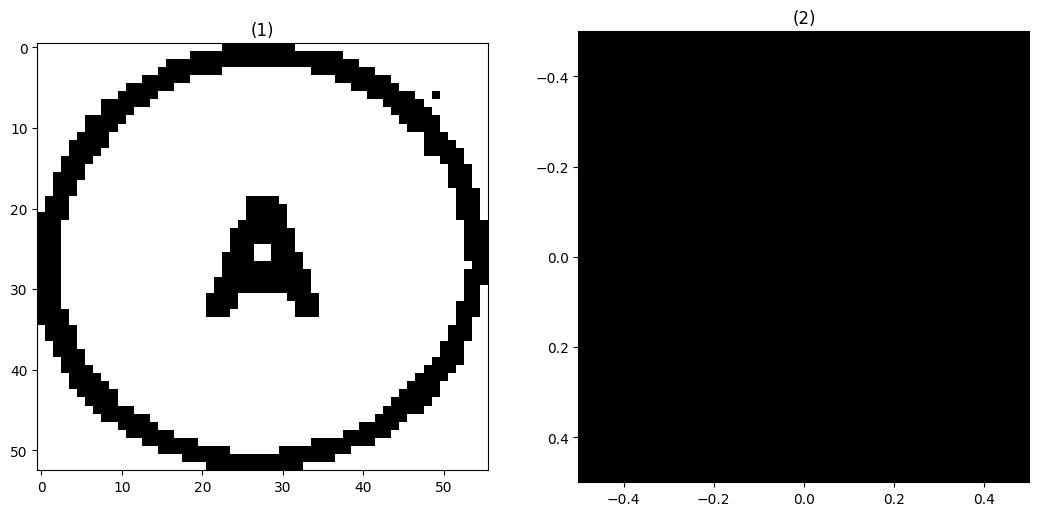

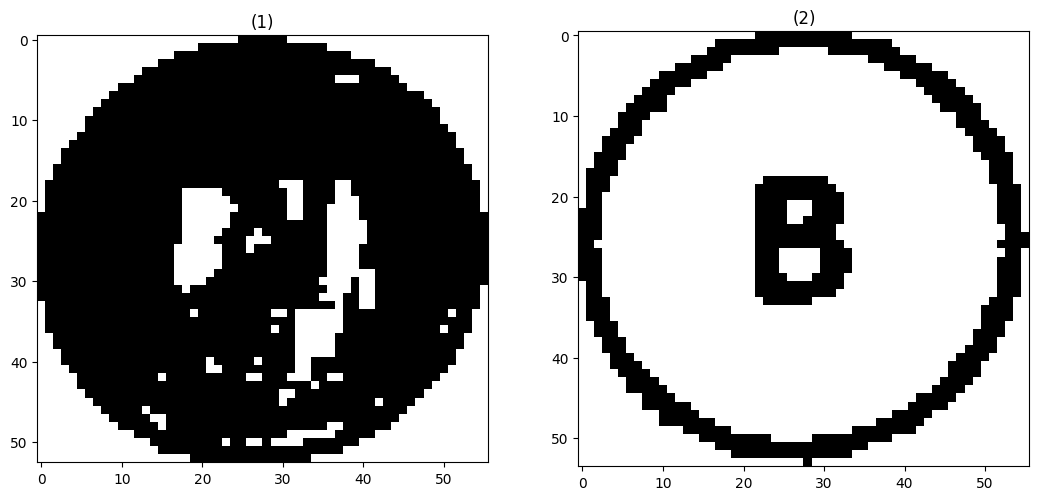

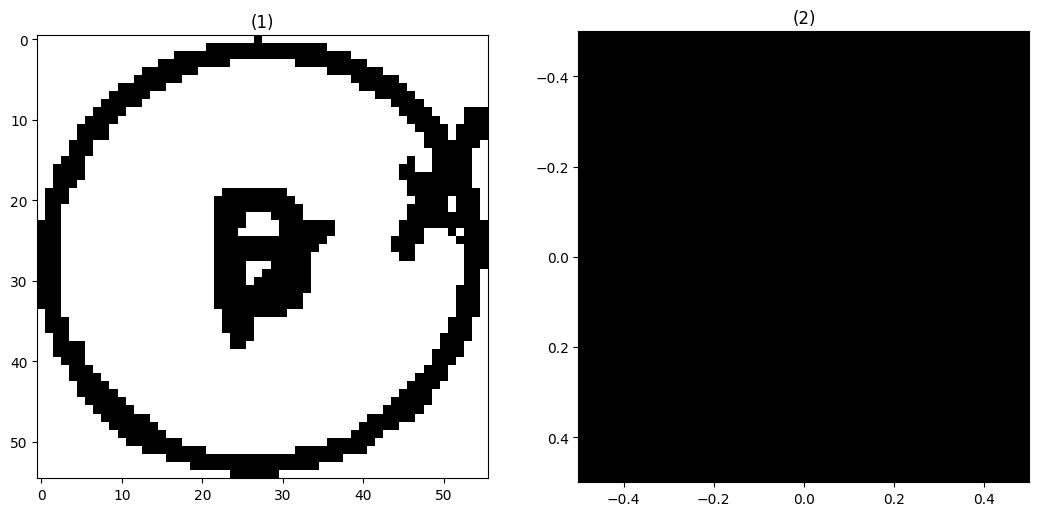

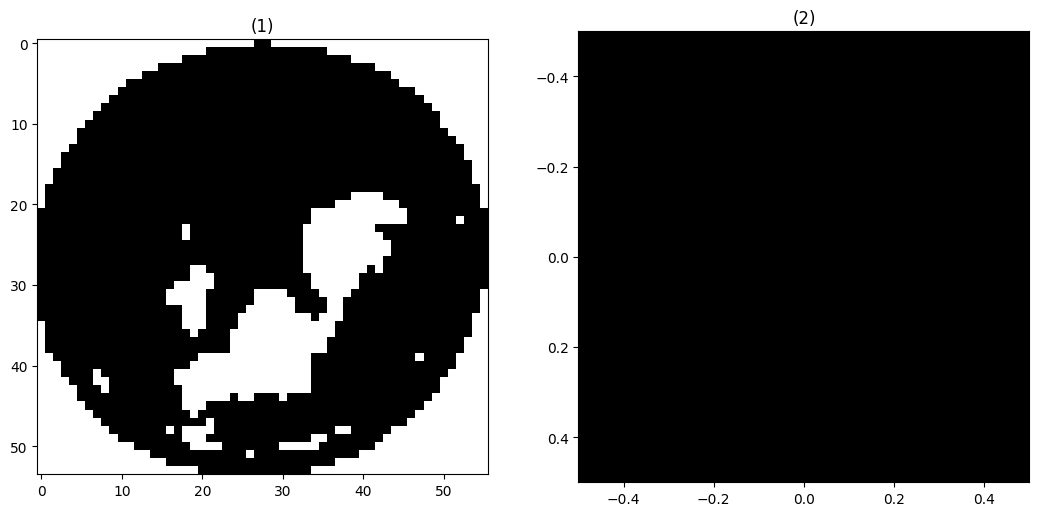

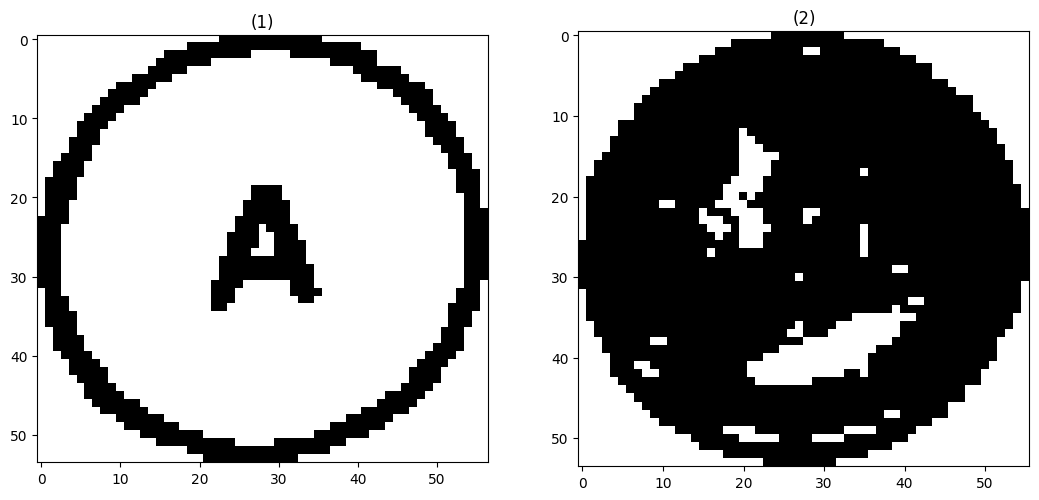

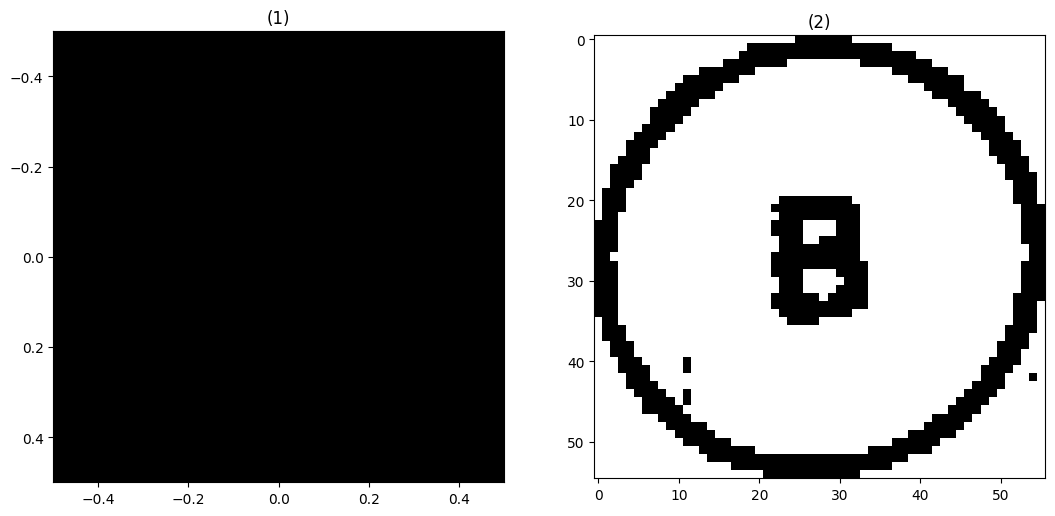

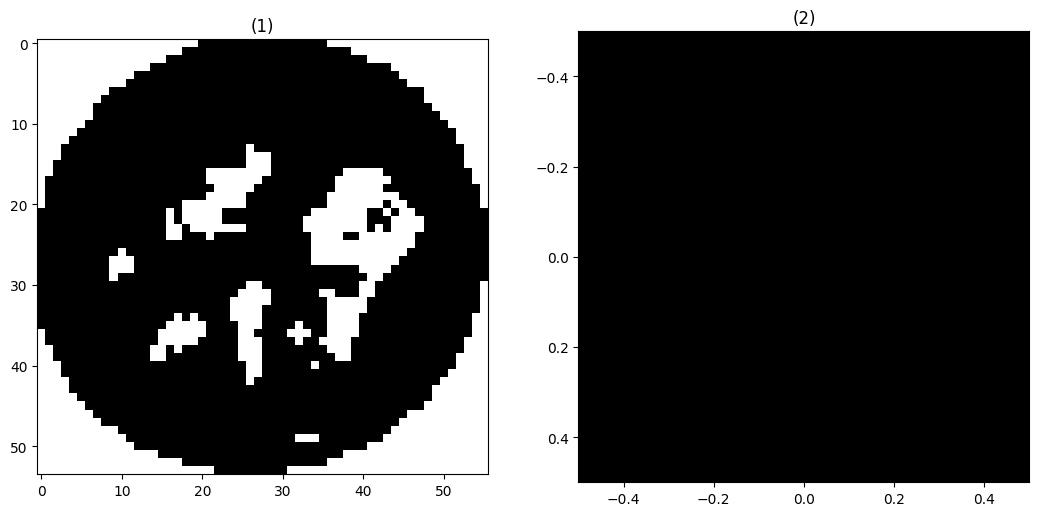

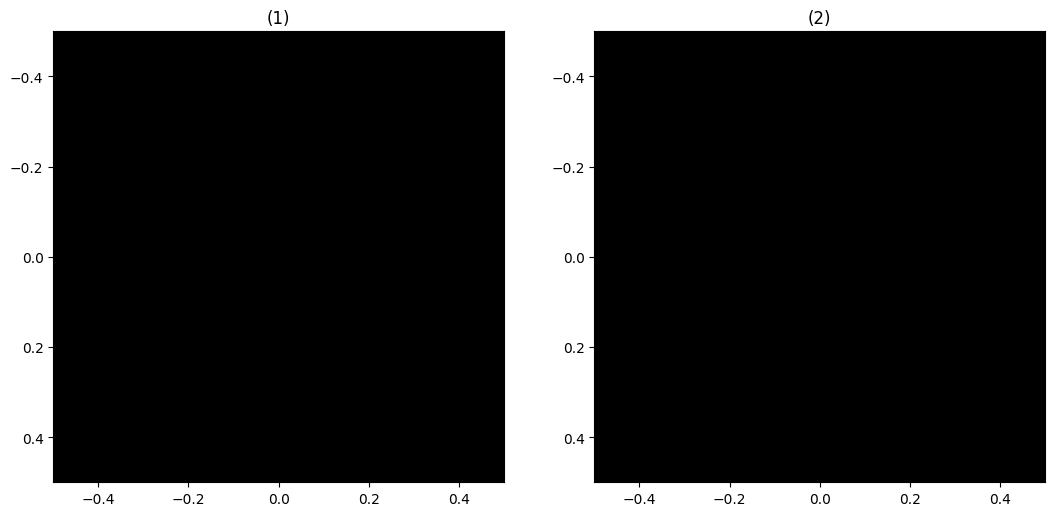

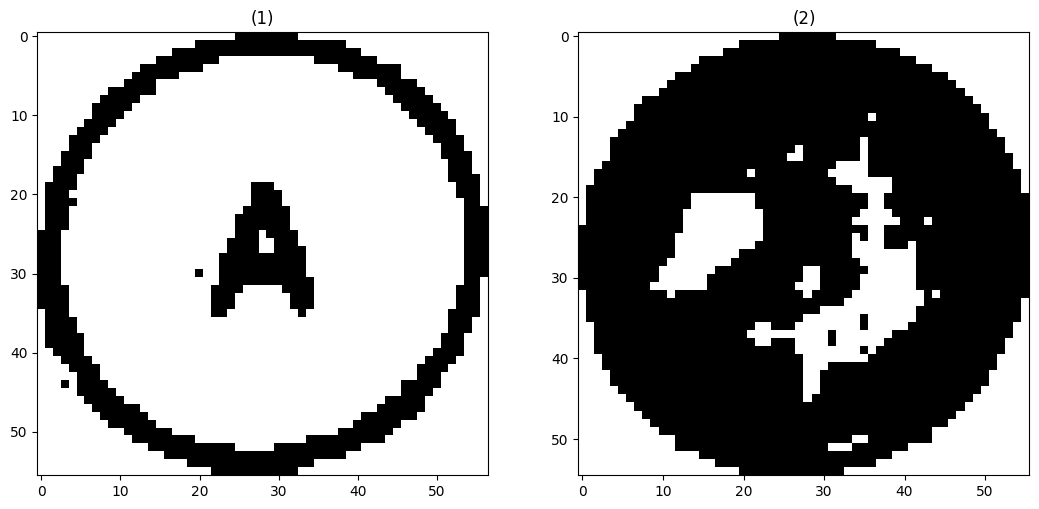

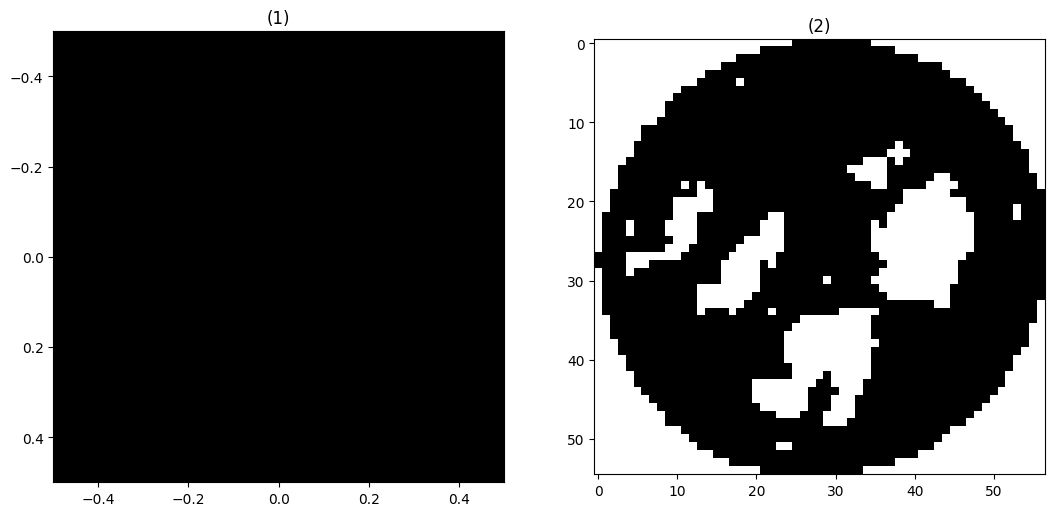

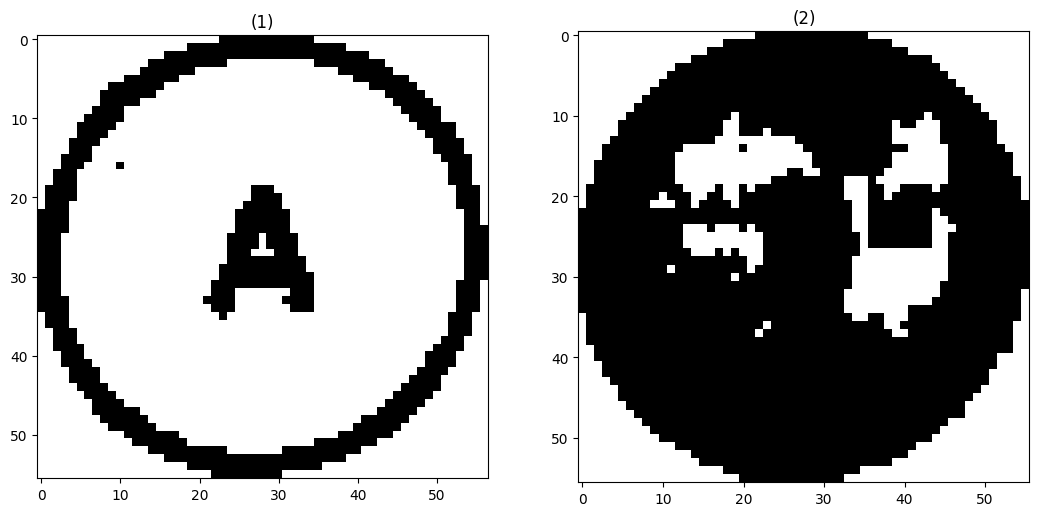

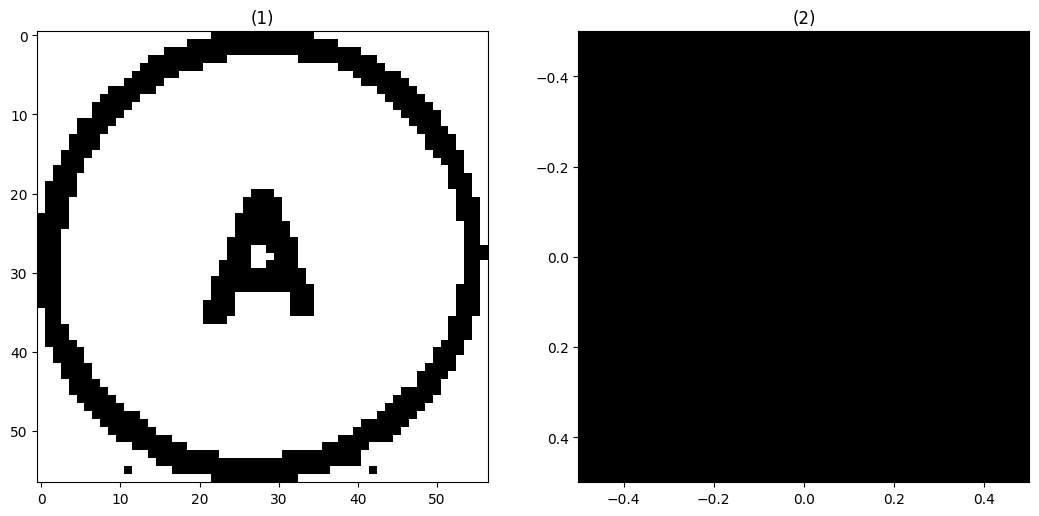

group 23


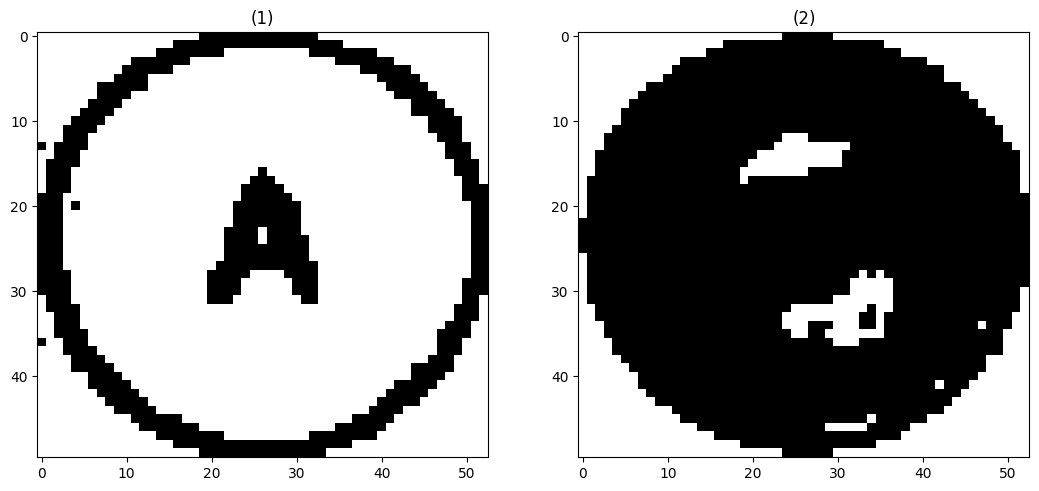

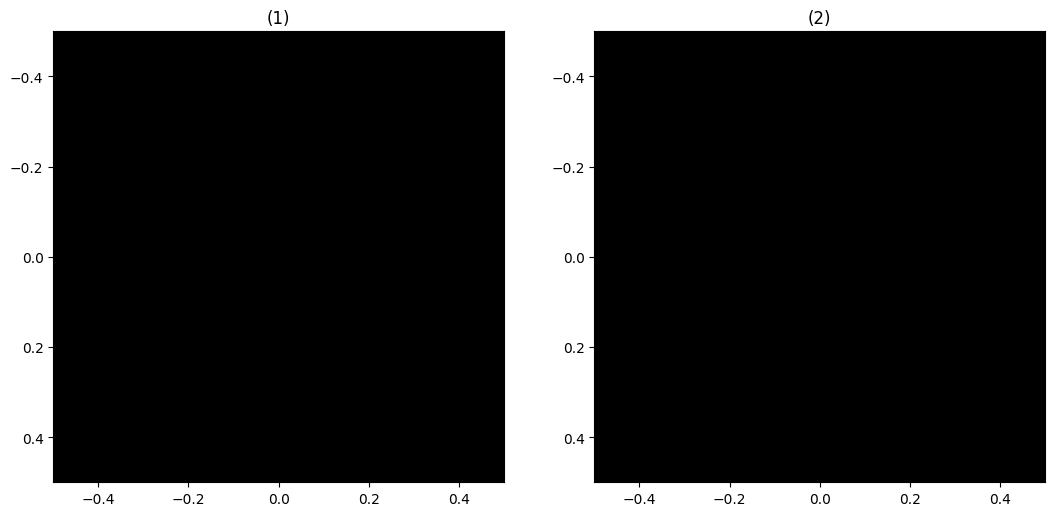

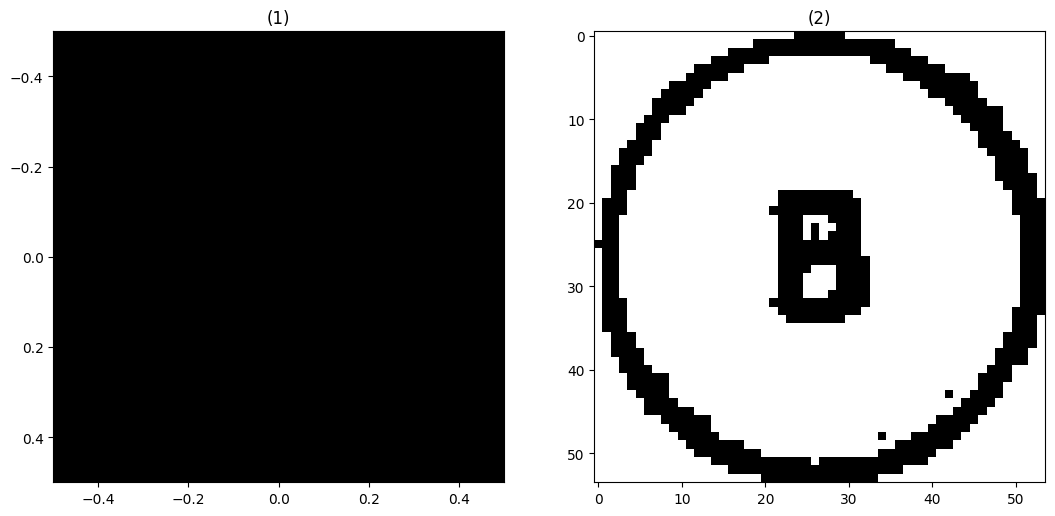

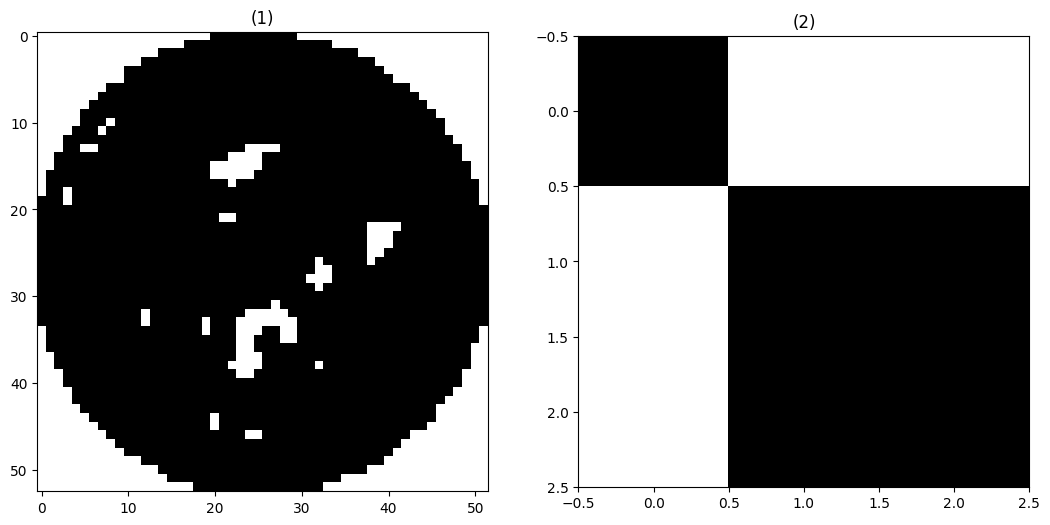

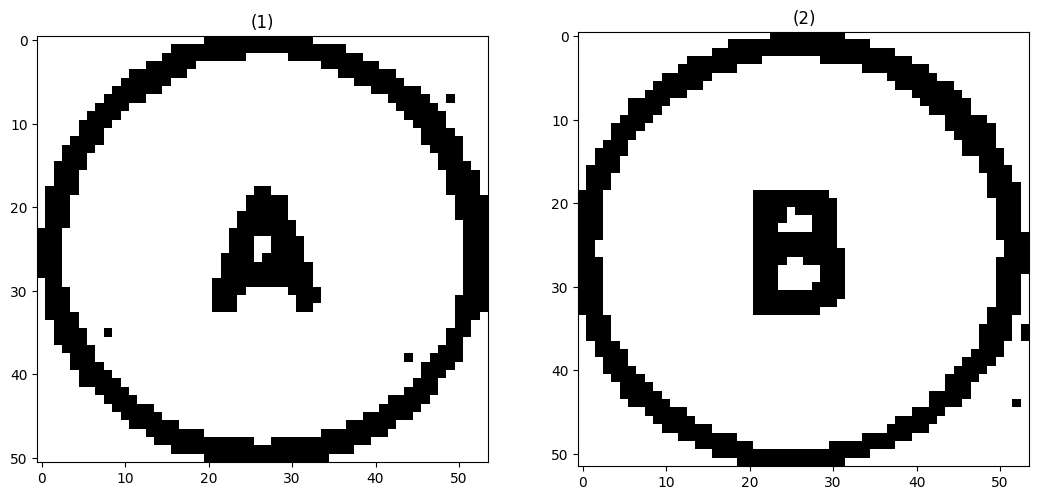

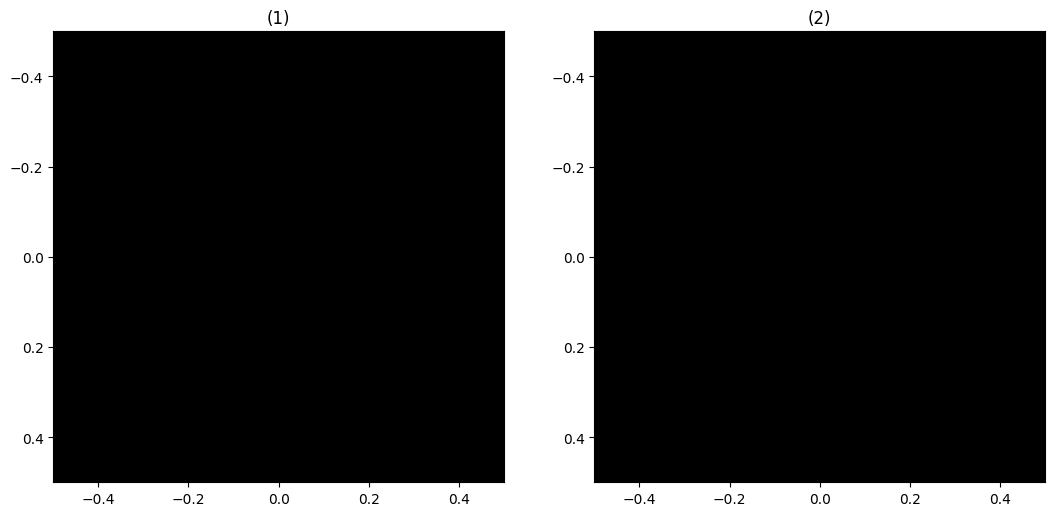

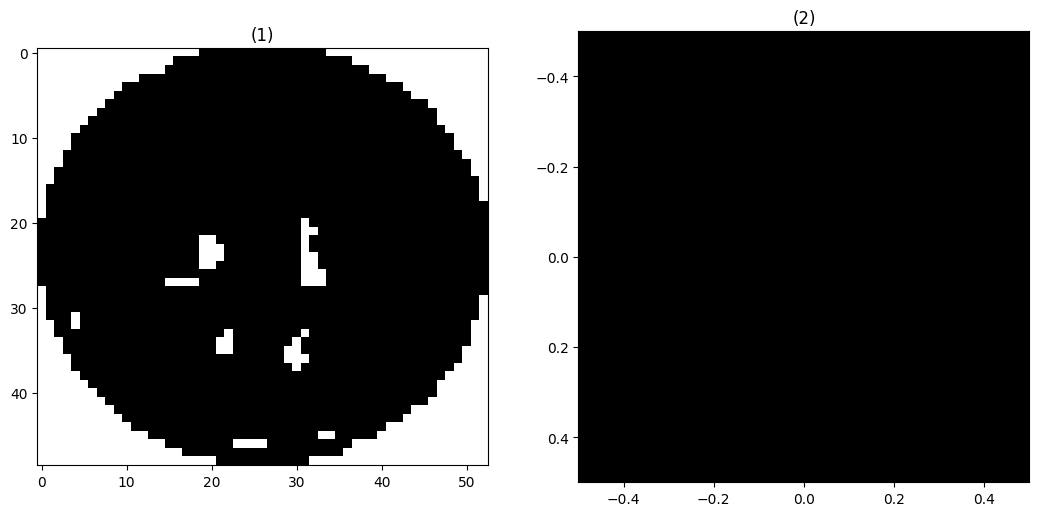

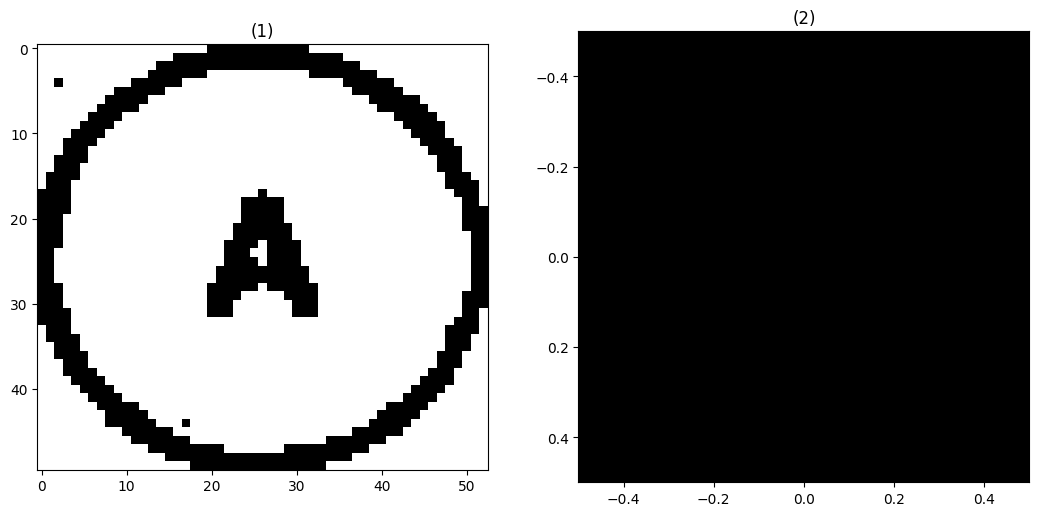

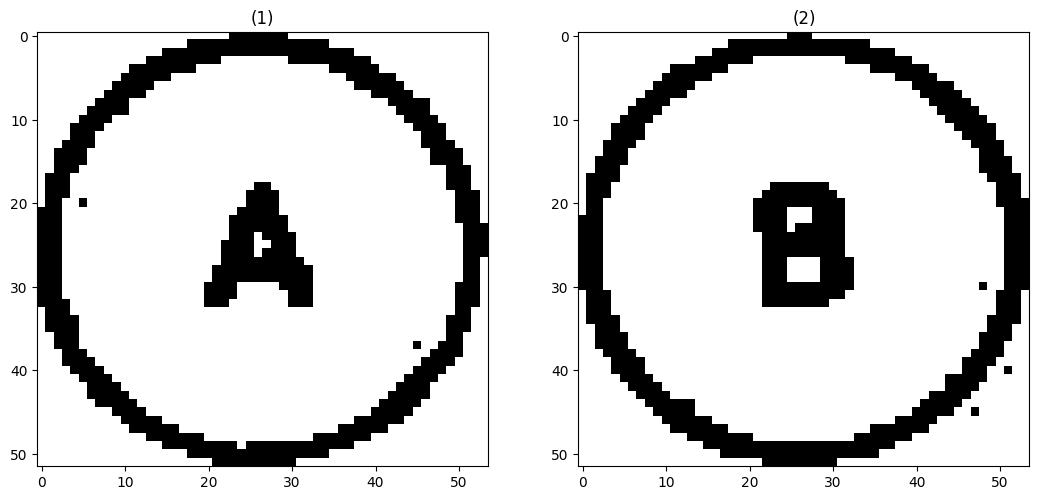

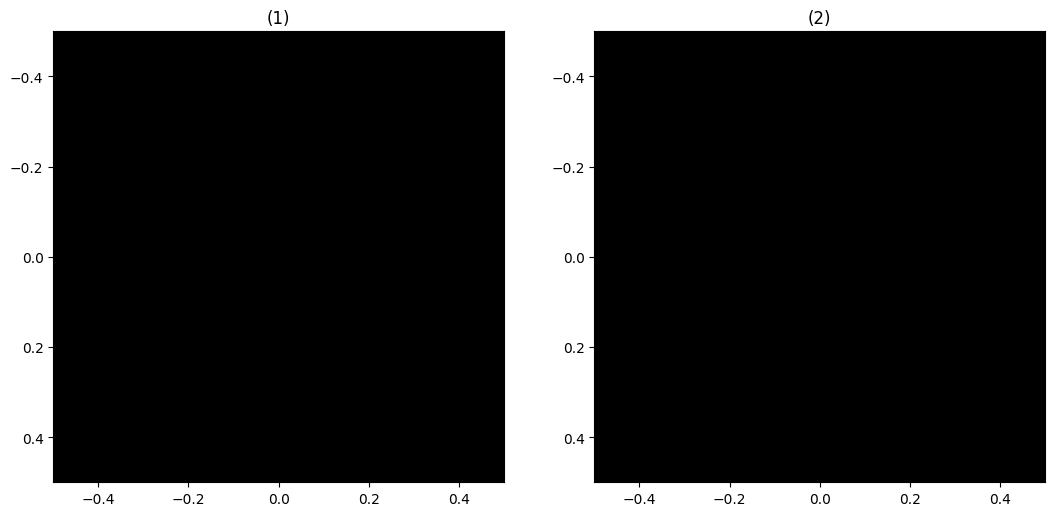

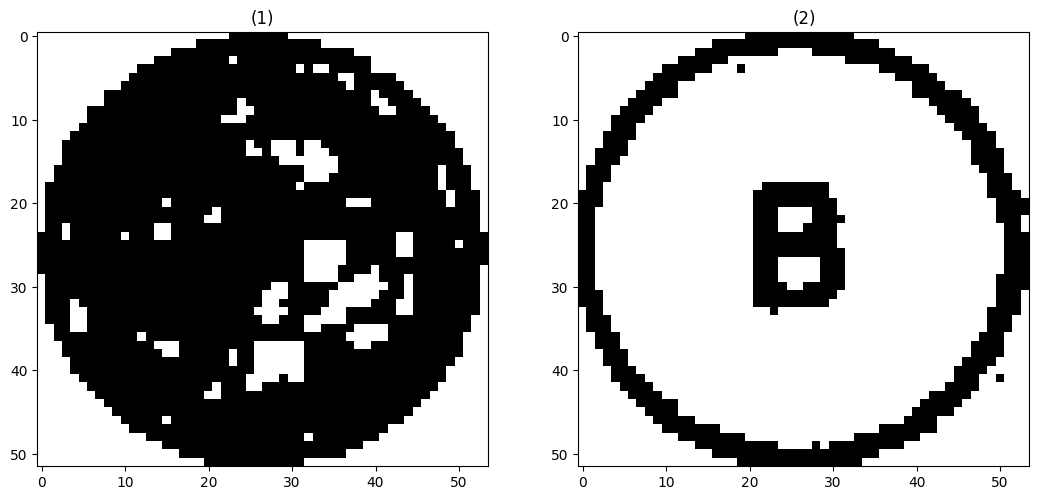

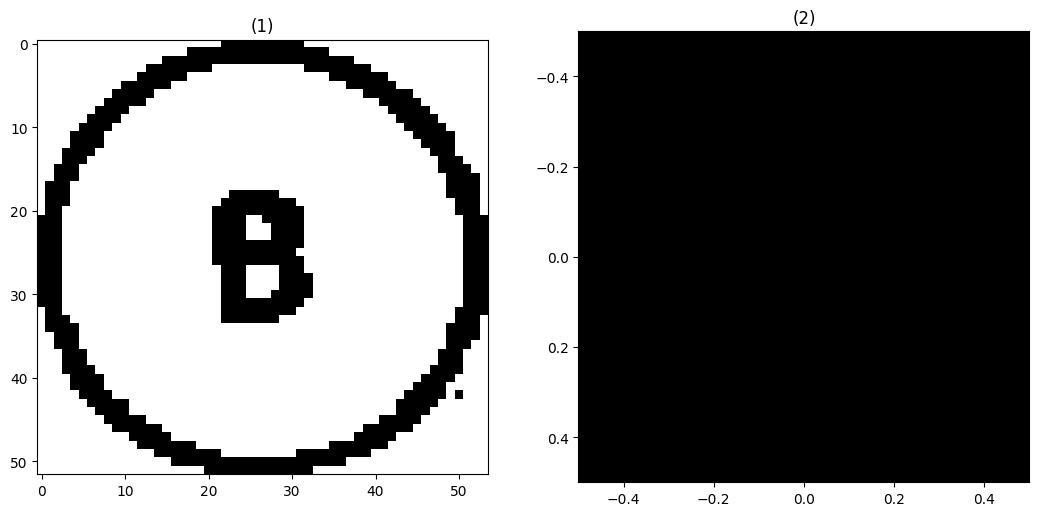

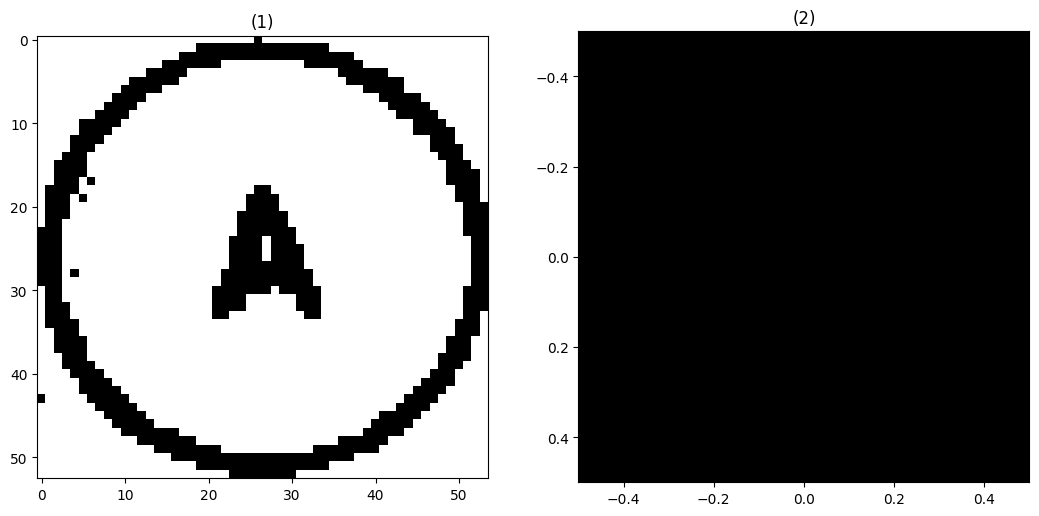

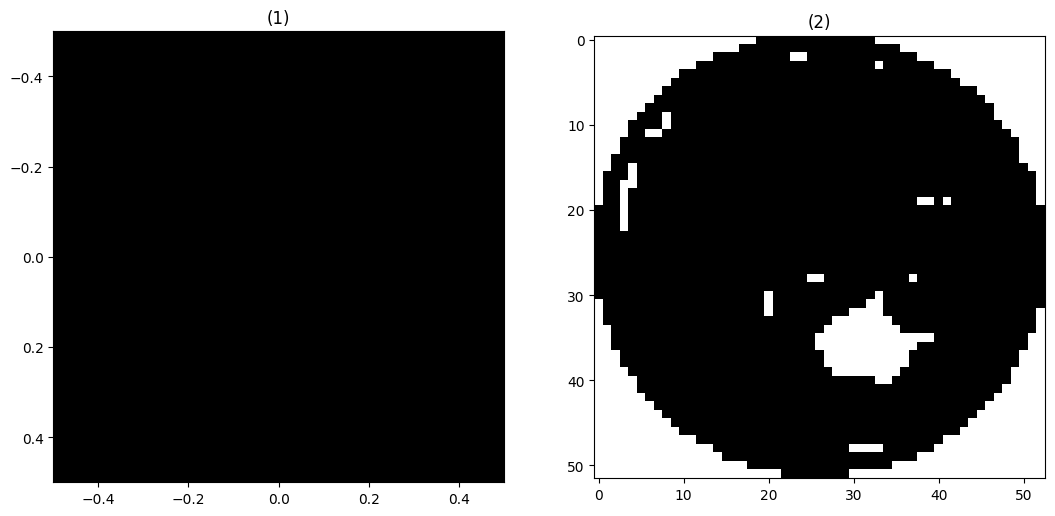

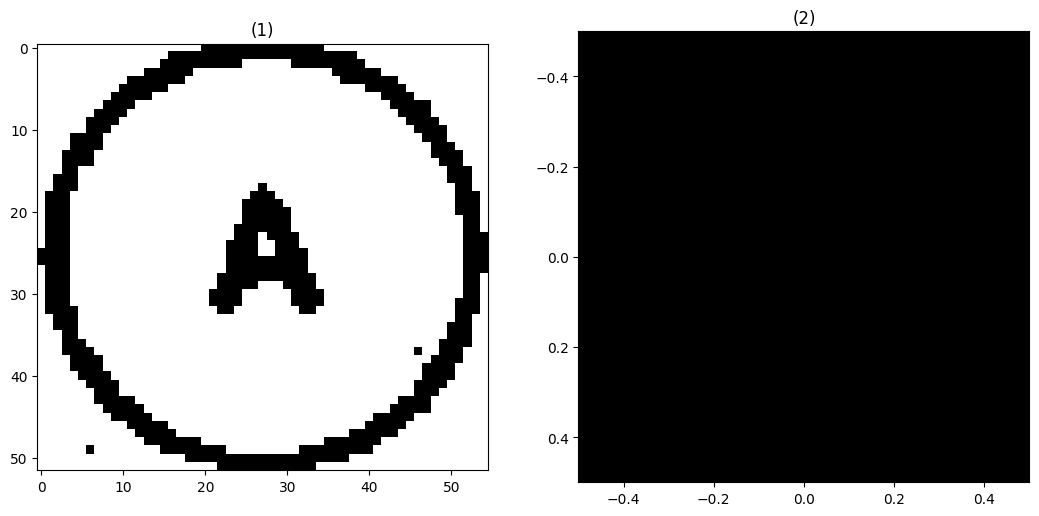

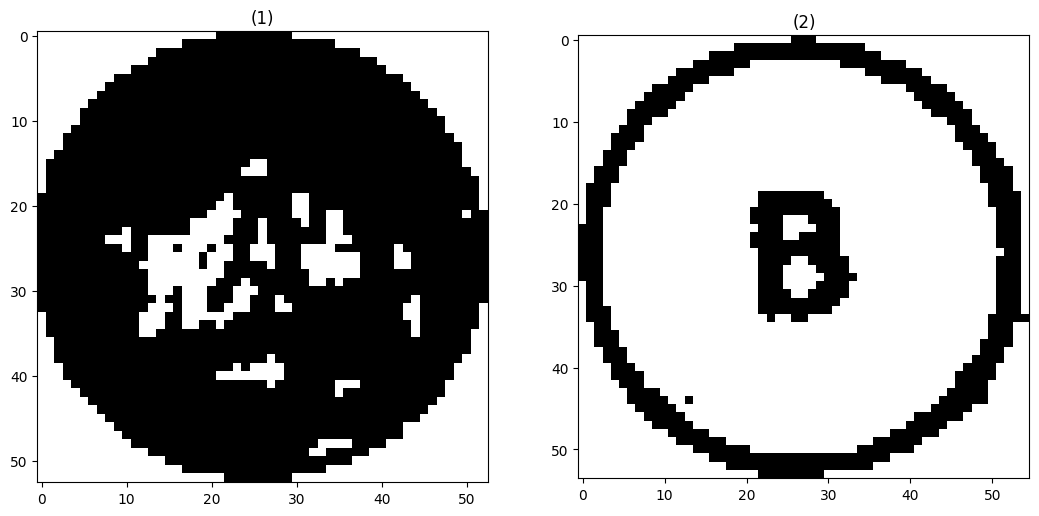

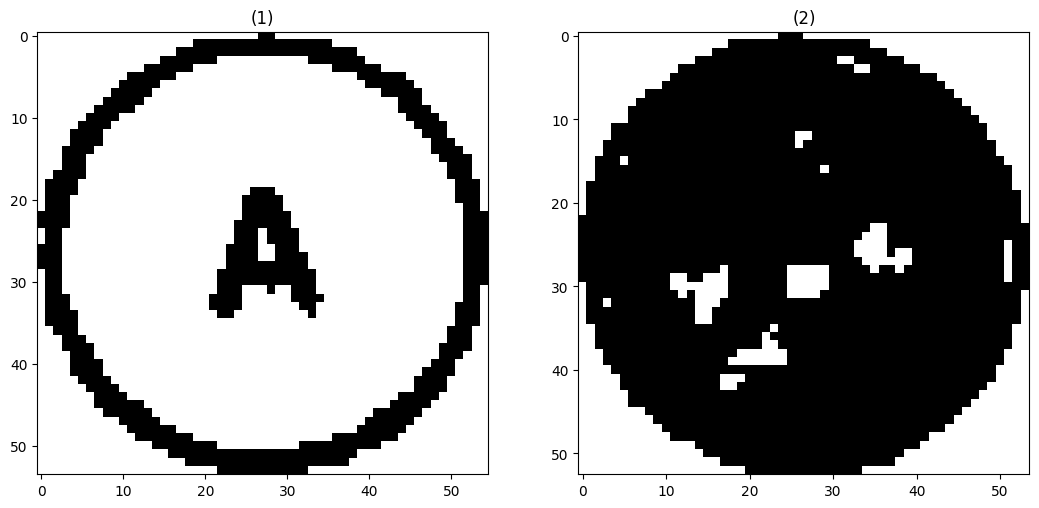

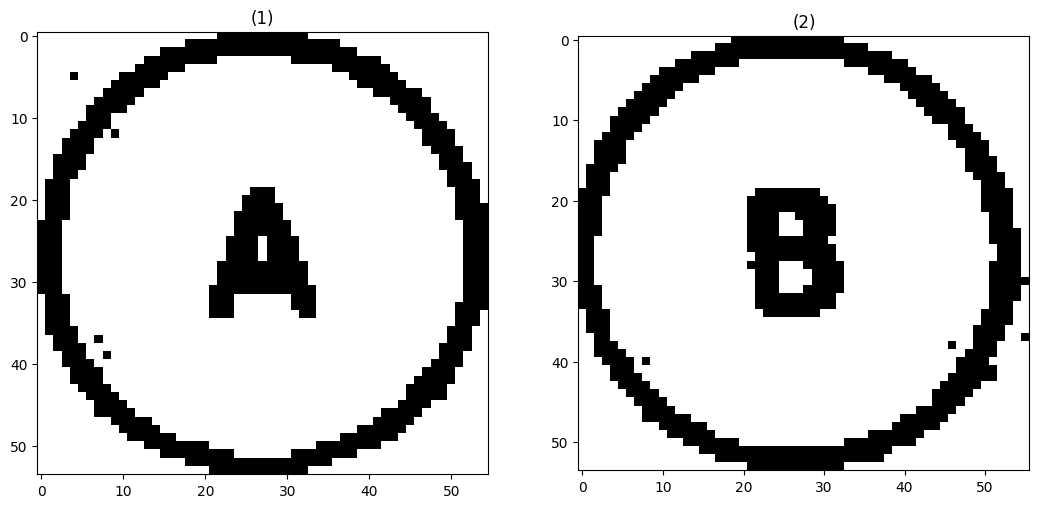

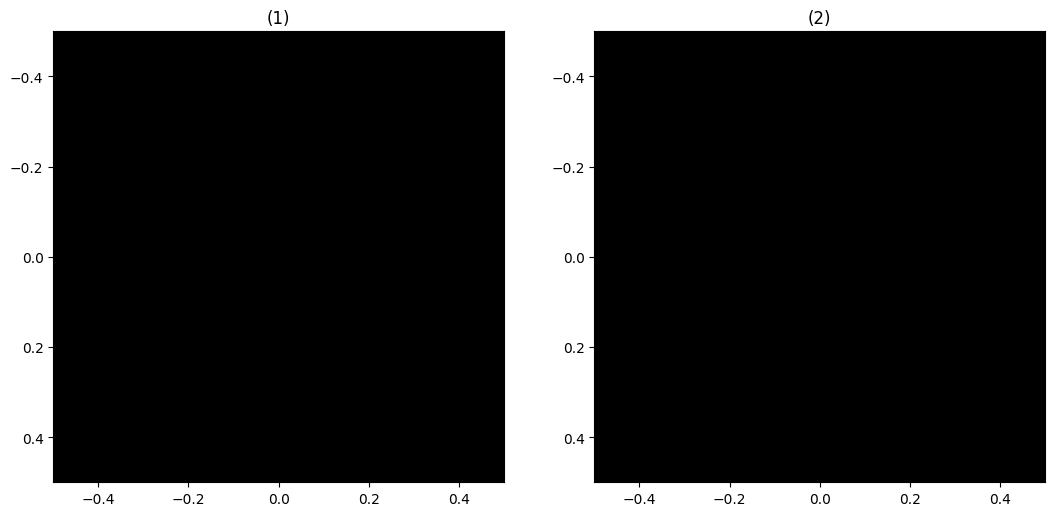

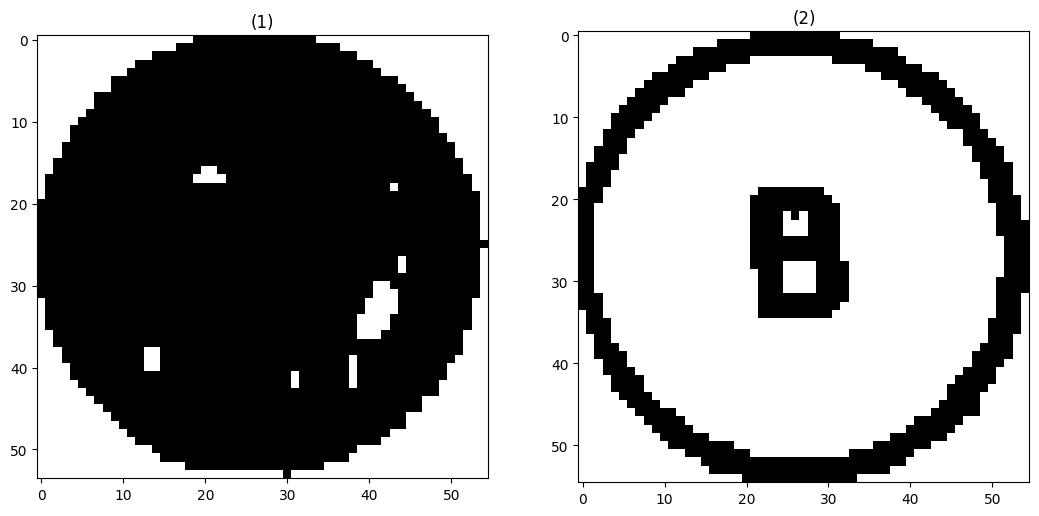

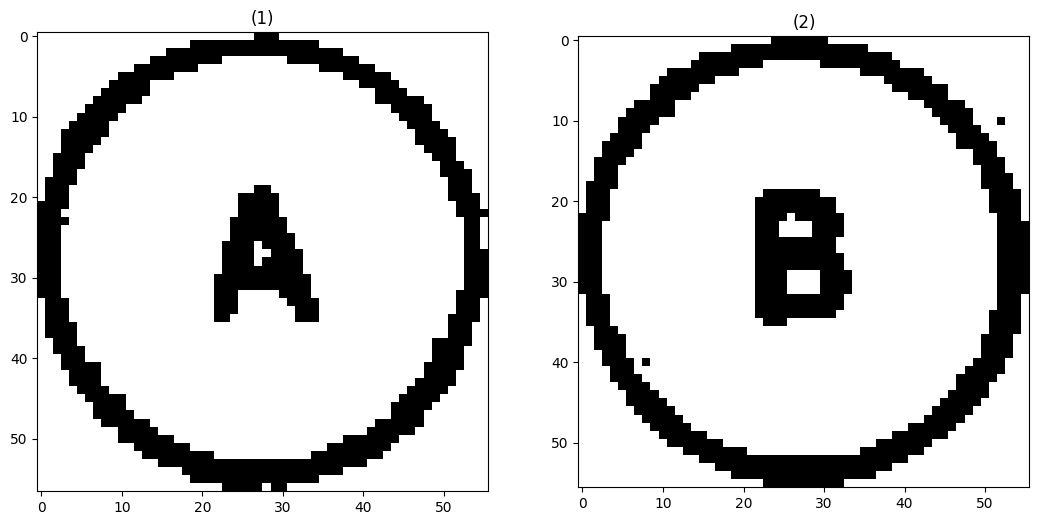

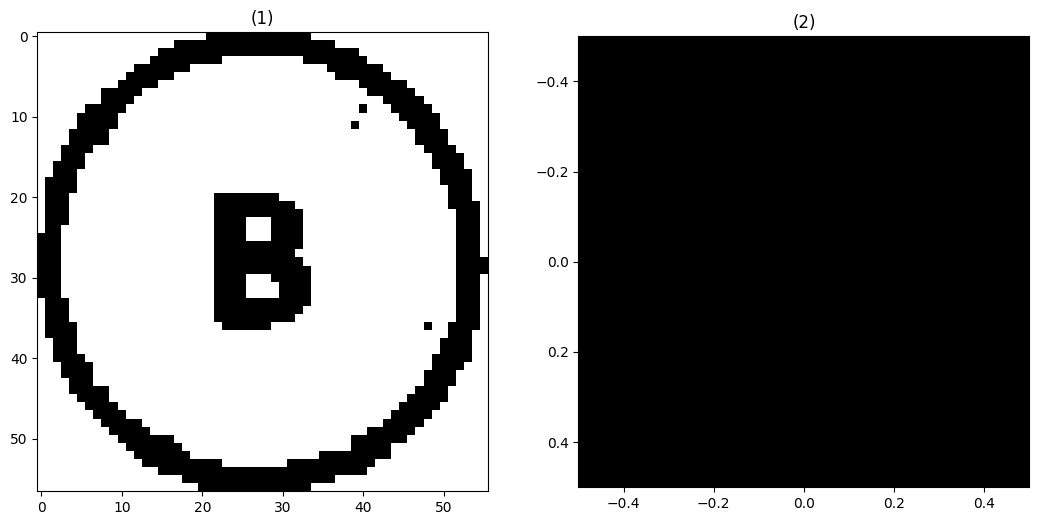

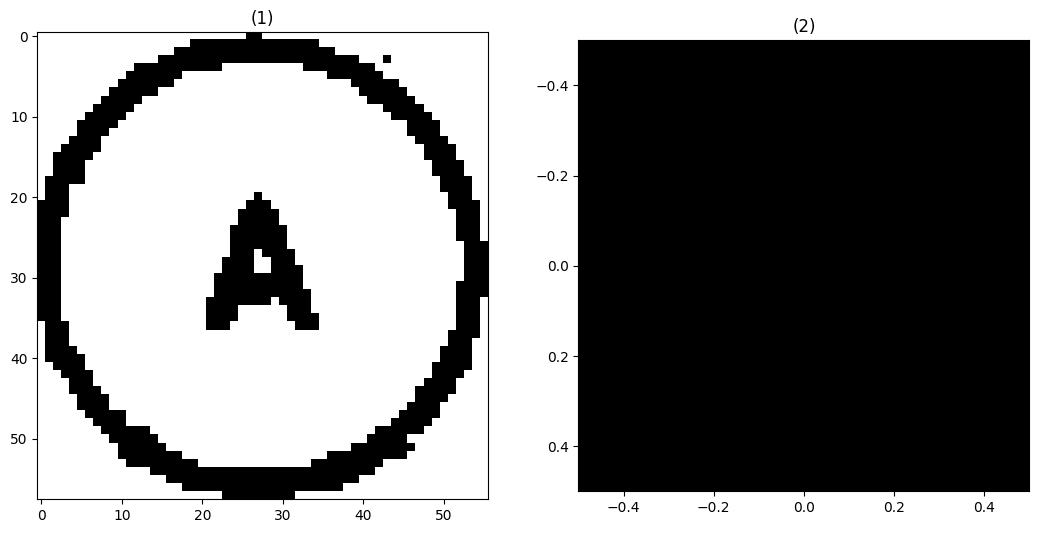

In [16]:
# print(groups_questions_answers[0][0].shape)
# print(len(groups_questions_answers[0][0]))
# show_images(groups_questions_answers[0])
count = 0
print("groups_questions_answers",len(groups_questions_answers))
for group in groups_questions_answers:
    print("group",len(group))
    for question in group:
        show_images(question)
        
                
        #print(question)
#         show_images(question)

In [17]:
question_index = 0
for group in groups_questions_answers:
#     group_ans = []
    for question in group:
        question_index = question_index+1
        ans = []
        for i in range(answer_count):
            choice = question[i]
            #print(np.sum(choice), 0.5*(255*choice.shape[0]*choice.shape[1]))
            if np.sum(choice) < 0.5*(255*choice.shape[0]*choice.shape[1]):
                ans.append(i+1)
        print("answer(s) for question ",question_index,"is",ans)
                

answer(s) for question  1 is [2]
answer(s) for question  2 is [2]
answer(s) for question  3 is [1, 2]
answer(s) for question  4 is [2]
answer(s) for question  5 is [1, 2]
answer(s) for question  6 is [1, 2]
answer(s) for question  7 is [2]
answer(s) for question  8 is [1]
answer(s) for question  9 is [2]
answer(s) for question  10 is [2]
answer(s) for question  11 is [1, 2]
answer(s) for question  12 is [2]
answer(s) for question  13 is [1]
answer(s) for question  14 is [2]
answer(s) for question  15 is [1, 2]
answer(s) for question  16 is [2]
answer(s) for question  17 is [1]
answer(s) for question  18 is [1, 2]
answer(s) for question  19 is [1, 2]
answer(s) for question  20 is [2]
answer(s) for question  21 is [1, 2]
answer(s) for question  22 is [2]
answer(s) for question  23 is [2]
answer(s) for question  24 is [2]
answer(s) for question  25 is [1, 2]
answer(s) for question  26 is [1]
answer(s) for question  27 is [1, 2]
answer(s) for question  28 is []
answer(s) for question  29 i

In [18]:
# # Read image.
# img = cv.imread('dataset/inputs/Four.png',0)

# # use canny to detect edges
# cannyEdges = cannyEdge(img)

# white_img_contours = np.ones(img.shape)
# contours, hierarchy = cv.findContours(cannyEdges, 
#     cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

# cv.drawContours(white_img_contours, contours, -1, (0,255,0), 3)

# show_images([white_img_contours])
# # Blur using 3 * 3 kernel.
# #gray_blurred = cv.blur(img, (3, 3))

# white_img = np.ones(img.shape)

# # Apply Hough transform on the blurred image.
# detected_circles = cv.HoughCircles(white_img_contours, 
#                    cv.HOUGH_GRADIENT, 1, 20, param1 = 50,
#                param2 = 30, minRadius = 1, maxRadius = 40)
  
# # Draw circles that are detected.
# if detected_circles is not None:
  
#     # Convert the circle parameters a, b and r to integers.
#     detected_circles = np.uint16(np.around(detected_circles))
  
#     for pt in detected_circles[0, :]:
#         a, b, r = pt[0], pt[1], pt[2]
  
#         # Draw the circumference of the circle.
#         cv.circle(img, (a, b), r, (0, 255, 0), 2)
  
#         # Draw a small circle (of radius 1) to show the center.
#         cv.circle(white_img, (a, b), 1, (0, 0, 255), 3)
# show_images([img,white_img])
